# OpMet Challenge - Including Observations & Resampling
The initial data pipeline only uses the forecast data as input to the ML pipeline. We could also use observations as input, although this reduces the usefulness of the algorithm as it can only be used for nowcasting. It is nonetheless to know how much additional skill models have when using observations compared to only using the forecast data.

An alternate to attempt to improve the classification performance is not to include more data but present it differently to the training process. This data has a *class imbalance* problem, in that there are far more data point without rotors compared to the number with rotors. We can resample the data so the training data we present to the algorithm has the same number of "rotor present" vs "no rotor" classes. We will start by trying a naive resmapling using pandas, and in subsequent investigate more sopjisticated resampling techniques that include generation of synthetic data points.

In [1]:
import pathlib
import datetime
import math
import functools
import numpy
import os

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas

In [3]:
import iris

In [4]:
import matplotlib

In [5]:
%matplotlib inline

In [6]:
import sklearn
import sklearn.tree
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.neural_network
import sklearn.metrics

In [55]:
import opmet_metrics

In [7]:
try:
    root_data_dir = os.environ['OPMET_DATA_ROOT']
except KeyError:
    root_data_dir = '/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge'
root_data_dir    

'/Users/stephen.haddad/data/ml_challenges/'

## Exploring Falklands Rotor Data

Start by loading the data, seeing what features we have.

In [8]:
falklands_dir = 'Rotors'
falklands_data_path = pathlib.Path(root_data_dir, falklands_dir)

In [9]:
falklands_new_training_data_path = pathlib.Path(falklands_data_path, 'new_training.csv')

In [10]:
falklands_training_df = pandas.read_csv(falklands_new_training_data_path, header=0).loc[1:,:]
falklands_training_df

,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,air_temp_4,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,Rotors 1 is true
1,01/01/2015 00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,282.625,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,NaN
2,01/01/2015 03:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,280.250,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,NaN
3,01/01/2015 06:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,278.625,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,NaN
4,01/01/2015 09:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,278.250,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,NaN
5,01/01/2015 12:00,279.9,277.4,120.0,8.7,-9999999.0,279.250,278.875,278.375,277.875,...,1.6,273.0,2.0,303.0,2.3,329.0,2.5,338.0,2.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,31/12/2020 06:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,277.500,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,NaN
20102,31/12/2020 09:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,NaN
20103,31/12/2020 12:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,279.625,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,NaN
20104,31/12/2020 15:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,283.000,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,NaN


In [11]:
falklands_training_df = falklands_training_df.drop_duplicates(subset='DTG')

In [12]:
falklands_training_df.shape

(17507, 95)

### Specify and create input features
Having loaded the data, we then do some preprocessing. This includes:
* Specify feature names
* convert wind speed / direction back to u/v wind. This is because these parameters will vary more smoothly for northerly winds, which is the wind we are interested in.
* prepare the target variable, including filling in missing data.

In [13]:
temp_feature_names = [f'air_temp_{i1}' for i1 in range(1,23)]
humidity_feature_names = [f'sh_{i1}' for i1 in range(1,23)]
wind_direction_feature_names = [f'winddir_{i1}' for i1 in range(1,23)]
wind_speed_feature_names = [f'windspd_{i1}' for i1 in range(1,23)]
target_feature_name = 'rotors_present'

In [14]:
obs_names = [
    'air_temp_obs',
    'dewpoint_obs',
    'wind_speed_obs',
    'wind_direction_obs',
]

obs_feature_names = [
    'air_temp_obs',
    'dewpoint_obs',
]

In [15]:
falklands_training_df[obs_names]

,air_temp_obs,dewpoint_obs,wind_speed_obs,wind_direction_obs
1,283.9,280.7,4.1,110.0
2,280.7,279.7,7.7,90.0
3,279.8,278.1,7.7,100.0
4,279.9,277.0,7.2,120.0
5,279.9,277.4,8.7,120.0
...,...,...,...,...
20101,276.7,275.5,3.6,270.0
20102,277.9,276.9,3.1,270.0
20103,283.5,277.1,3.6,220.0
20104,286.1,276.9,3.6,250.0


In [16]:
def get_v_wind(wind_dir_name, wind_speed_name, row1):
    return math.cos(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

def get_u_wind(wind_dir_name, wind_speed_name, row1):
    return math.sin(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

In [17]:
u_feature_template = 'u_wind_{level_ix}'
v_feature_template = 'v_wind_{level_ix}'
u_wind_feature_names = []
v_wind_features_names = []
for wsn1, wdn1 in zip(wind_speed_feature_names, wind_direction_feature_names):
    level_ix = int( wsn1.split('_')[1])
    u_feature = u_feature_template.format(level_ix=level_ix)
    u_wind_feature_names += [u_feature]
    falklands_training_df[u_feature] = falklands_training_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
    v_feature = v_feature_template.format(level_ix=level_ix)
    v_wind_features_names += [v_feature]
    falklands_training_df[v_feature] = falklands_training_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_15320/4212466182.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df[u_feature] = falklands_training_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_15320/4212466182.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df[v_feature] = falklands_training_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')


In [18]:
wdn1 = 'wind_direction_obs'
wsn1 = 'wind_speed_obs'
u_feature = u_feature_template.format(level_ix='obs')
obs_feature_names += [u_feature]
falklands_training_df[u_feature] = falklands_training_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
v_feature = v_feature_template.format(level_ix='obs')
obs_feature_names += [v_feature]
falklands_training_df[v_feature] = falklands_training_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_15320/495145632.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df[u_feature] = falklands_training_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_15320/495145632.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df[v_feature] = falklands_training_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')


In [19]:
falklands_training_df[obs_feature_names]

,air_temp_obs,dewpoint_obs,u_wind_obs,v_wind_obs
1,283.9,280.7,3.852740,-1.402283e+00
2,280.7,279.7,7.700000,4.714890e-16
3,279.8,278.1,7.583020,-1.337091e+00
4,279.9,277.0,6.235383,-3.600000e+00
5,279.9,277.4,7.534421,-4.350000e+00
...,...,...,...,...
20101,276.7,275.5,-3.600000,-6.613093e-16
20102,277.9,276.9,-3.100000,-5.694608e-16
20103,283.5,277.1,-2.314035,-2.757760e+00
20104,286.1,276.9,-3.382893,-1.231273e+00


In [20]:
falklands_training_df[target_feature_name] =  falklands_training_df['Rotors 1 is true']
falklands_training_df.loc[falklands_training_df[falklands_training_df['Rotors 1 is true'].isna()].index, target_feature_name] = 0.0
falklands_training_df[target_feature_name]  = falklands_training_df[target_feature_name] .astype(bool)

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_15320/2394283915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df[target_feature_name] =  falklands_training_df['Rotors 1 is true']
/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-sklearn/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_15320/2394283915.py:3: 

In [21]:
falklands_training_df[target_feature_name].value_counts()

False    17058
True       449
Name: rotors_present, dtype: int64

In [22]:
falklands_training_df.columns

Index(['DTG', 'air_temp_obs', 'dewpoint_obs', 'wind_direction_obs',
       'wind_speed_obs', 'wind_gust_obs', 'air_temp_1', 'air_temp_2',
       'air_temp_3', 'air_temp_4',
       ...
       'v_wind_19', 'u_wind_20', 'v_wind_20', 'u_wind_21', 'v_wind_21',
       'u_wind_22', 'v_wind_22', 'u_wind_obs', 'v_wind_obs', 'rotors_present'],
      dtype='object', length=142)

### Split into traing/validate/test sets
Next step is to split into train/validate/test sets. We split the pandas data frame, then then later extract the actual training data from the dataframe.

In [24]:
test_fraction = 0.1
validation_fraction = 0.1

In [25]:
num_no_rotors = sum(falklands_training_df[target_feature_name] == False)
num_with_rotors = sum(falklands_training_df[target_feature_name] == True)

In [26]:
data_no_rotors = falklands_training_df[falklands_training_df[target_feature_name] == False]
data_with_rotors = falklands_training_df[falklands_training_df[target_feature_name] == True]

In [27]:
data_test = pandas.concat([data_no_rotors.sample(int(test_fraction * num_no_rotors)), data_with_rotors.sample(int(test_fraction * num_with_rotors))])
data_test[target_feature_name].value_counts()

False    1705
True       44
Name: rotors_present, dtype: int64

In [28]:
falklands_training_df['test_set'] = False
falklands_training_df.loc[data_test.index,'test_set'] = True

In [29]:
data_working = falklands_training_df[falklands_training_df['test_set'] == False]
data_working_no_rotors = data_working[data_working[target_feature_name] == False]
data_working_with_rotors = data_working[data_working[target_feature_name] == True]

In [30]:
data_validation = pandas.concat(
    [data_working_no_rotors.sample(int(validation_fraction * num_no_rotors)), 
     data_working_with_rotors.sample(int(validation_fraction * num_with_rotors))])
falklands_training_df['validation_set'] = False
falklands_training_df.loc[data_validation.index,'validation_set'] = True

In [31]:
data_validation[target_feature_name].value_counts()

False    1705
True       44
Name: rotors_present, dtype: int64

In [32]:
data_train = falklands_training_df[(~falklands_training_df['test_set']) & (~falklands_training_df['validation_set'])]

In [33]:
data_train[target_feature_name].value_counts()

False    13648
True       361
Name: rotors_present, dtype: int64

## Traing and evaluate machine learning models
Having loaded and transformed the data, we do final prrocessing, train several different classifiers representing different classification algorithms, then evaluate performance.


### Preprocess data into input for ML algorithm
The first step is doing the final preprocessing such as tranforming continous features to have zero mean and unit standard deviation.

In [34]:
input_feature_names = temp_feature_names + humidity_feature_names + u_wind_feature_names + v_wind_features_names

In [35]:
preproc_dict = {}
for if1 in input_feature_names:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(data_train[[if1]])
    preproc_dict[if1] = scaler1

In [36]:
target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(data_train[[target_feature_name]])

LabelEncoder()

Apply transformation to each input column

In [37]:
def preproc_input(data_subset, pp_dict):
    return numpy.concatenate([scaler1.transform(data_subset[[if1]]) for if1,scaler1 in pp_dict.items()],axis=1)

def preproc_target(data_subset, enc1):
     return enc1.transform(data_subset[[target_feature_name]])

In [38]:
X_train = preproc_input(data_train, preproc_dict)
y_train = preproc_target(data_train, target_encoder)

create target feature from rotors

In [39]:
y_train.shape, X_train.shape

((14009,), (14009, 88))

In [40]:
X_val = preproc_input(data_validation, preproc_dict)
y_val = preproc_target(data_validation, target_encoder)

In [41]:
X_test = preproc_input(data_test, preproc_dict)
y_test = preproc_target(data_test, target_encoder)

In [42]:
train_val_test_tuples = [
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),    
]

In [72]:
train_test_dict = {
    'train':     (X_train, y_train),
    'validate':     (X_val, y_val),
    'test': (X_test, y_test),
}
train_val_test_tuples = list(train_test_dict.values())

### Train classifiers

At last we are ready to do machine learning! We will try different algorithms, including a tree based methods, ensembles of trees and neural networks.

In [43]:
classifiers_params = {
    'decision_tree': {'class': sklearn.tree.DecisionTreeClassifier, 'opts': {'max_depth':10, 'class_weight':'balanced'}},
    'random_forest': {'class': sklearn.ensemble.RandomForestClassifier, 'opts': {'max_depth':10, 'class_weight':'balanced'}},
     'ann_5_500': {'class': sklearn.neural_network.MLPClassifier, 'opts': {'hidden_layer_sizes':(500,500,500,500,500)}},   
     'ann_3_700': {'class': sklearn.neural_network.MLPClassifier, 'opts': {'hidden_layer_sizes':(700,700,700)}},   
}



In [44]:
%%time
classifiers_dict = {}             
for clf_name, clf_params in classifiers_params.items():
    print(clf_name)
    clf1 = clf_params['class'](**clf_params['opts'])
    clf1.fit(X_train, y_train)
    classifiers_dict[clf_name] = clf1

decision_tree
random_forest
ann_5_500
ann_3_700
CPU times: user 25min 11s, sys: 32.2 s, total: 25min 43s
Wall time: 6min 48s


### Evaluate classifier perforamnce
Now we take a look at how well our classifiers perform on training and valiation data.

In [60]:
import importlib

In [129]:
importlib.reload(opmet_metrics)

<module 'opmet_metrics' from '/Users/stephen.haddad/prog/data_science_cop/challenges/opmet_metrics.py'>

In [130]:
metrics, metrics_df_list = opmet_metrics.calculate_metric_suite(
    classifiers_dict, 
    train_test_dict,
)

<AxesSubplot:title={'center':'false alarm rate (validate) for rotors present class'}, xlabel='classifier'>

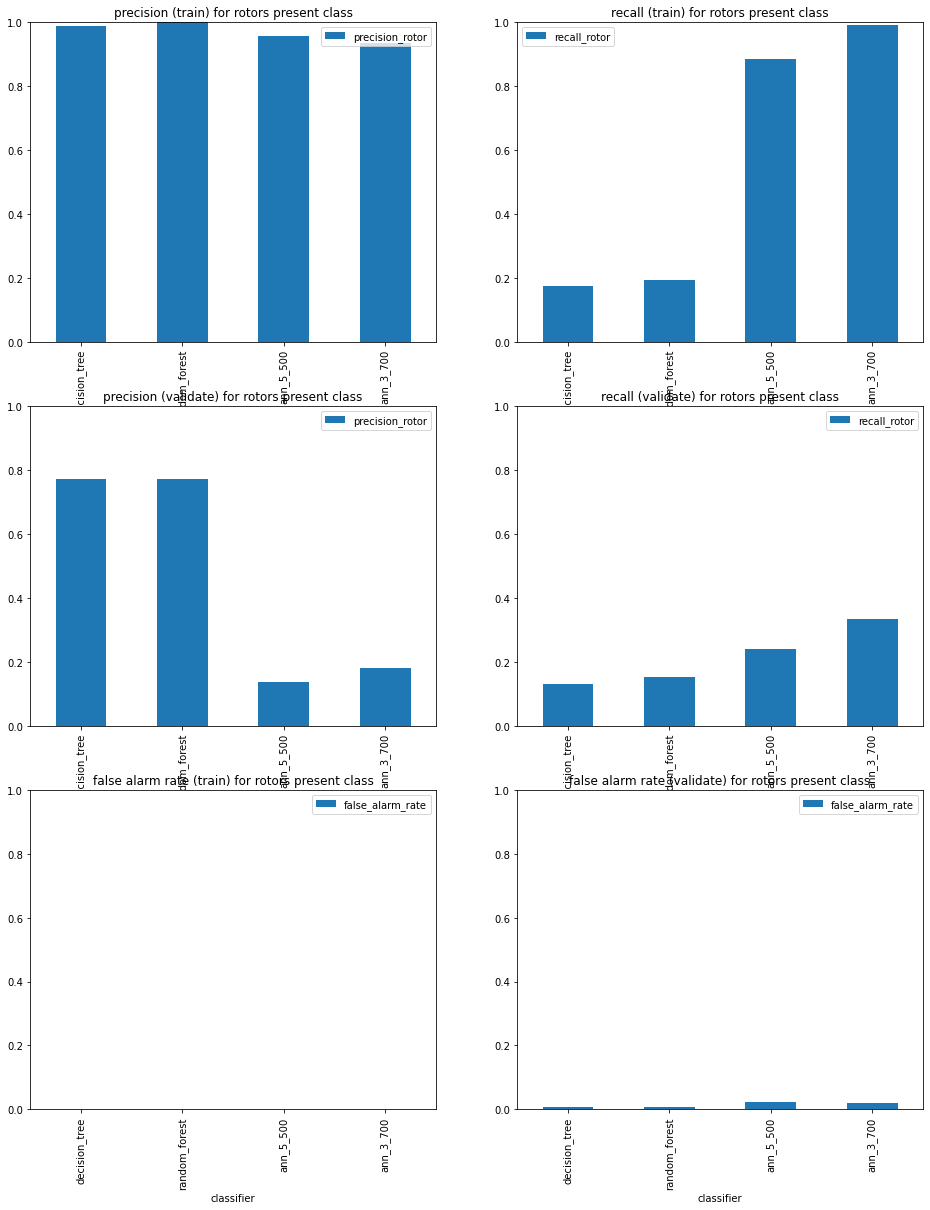

In [133]:
fig1 = matplotlib.pyplot.figure(figsize=(16,20))
ax1 = fig1.add_subplot(3,2,1,title='precision (train) for rotors present class')
metrics_df_list['train'].plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,2,title='recall (train) for rotors present class')
metrics_df_list['train'].plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,3,title='precision (validate) for rotors present class')
metrics_df_list['test'].plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,4,title='recall (validate) for rotors present class')
metrics_df_list['test'].plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,5,title='false alarm rate (train) for rotors present class')
metrics_df_list['train'].plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,6,title='false alarm rate (validate) for rotors present class')
metrics_df_list['test'].plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])

### Plot SEDI for different classifiers and thresholds

In [78]:
thresholds_list = list(numpy.arange(1e-3,0.995,5e-3))


In [99]:
sedi_dict = {}
for set_name, (X1, y1) in train_test_dict.items():
    set_sedi_dict = {}
    for clf_name, clf1 in classifiers_dict.items():
        y_pred_raw = clf1.predict_proba(X1)[:,1]
        set_sedi_dict[clf_name] = opmet_metrics.calculate_sedi_suite(thresholds_list,
                                                                     y1, 
                                                                     y_pred_raw)
        
    sedi_dict[set_name] = set_sedi_dict     

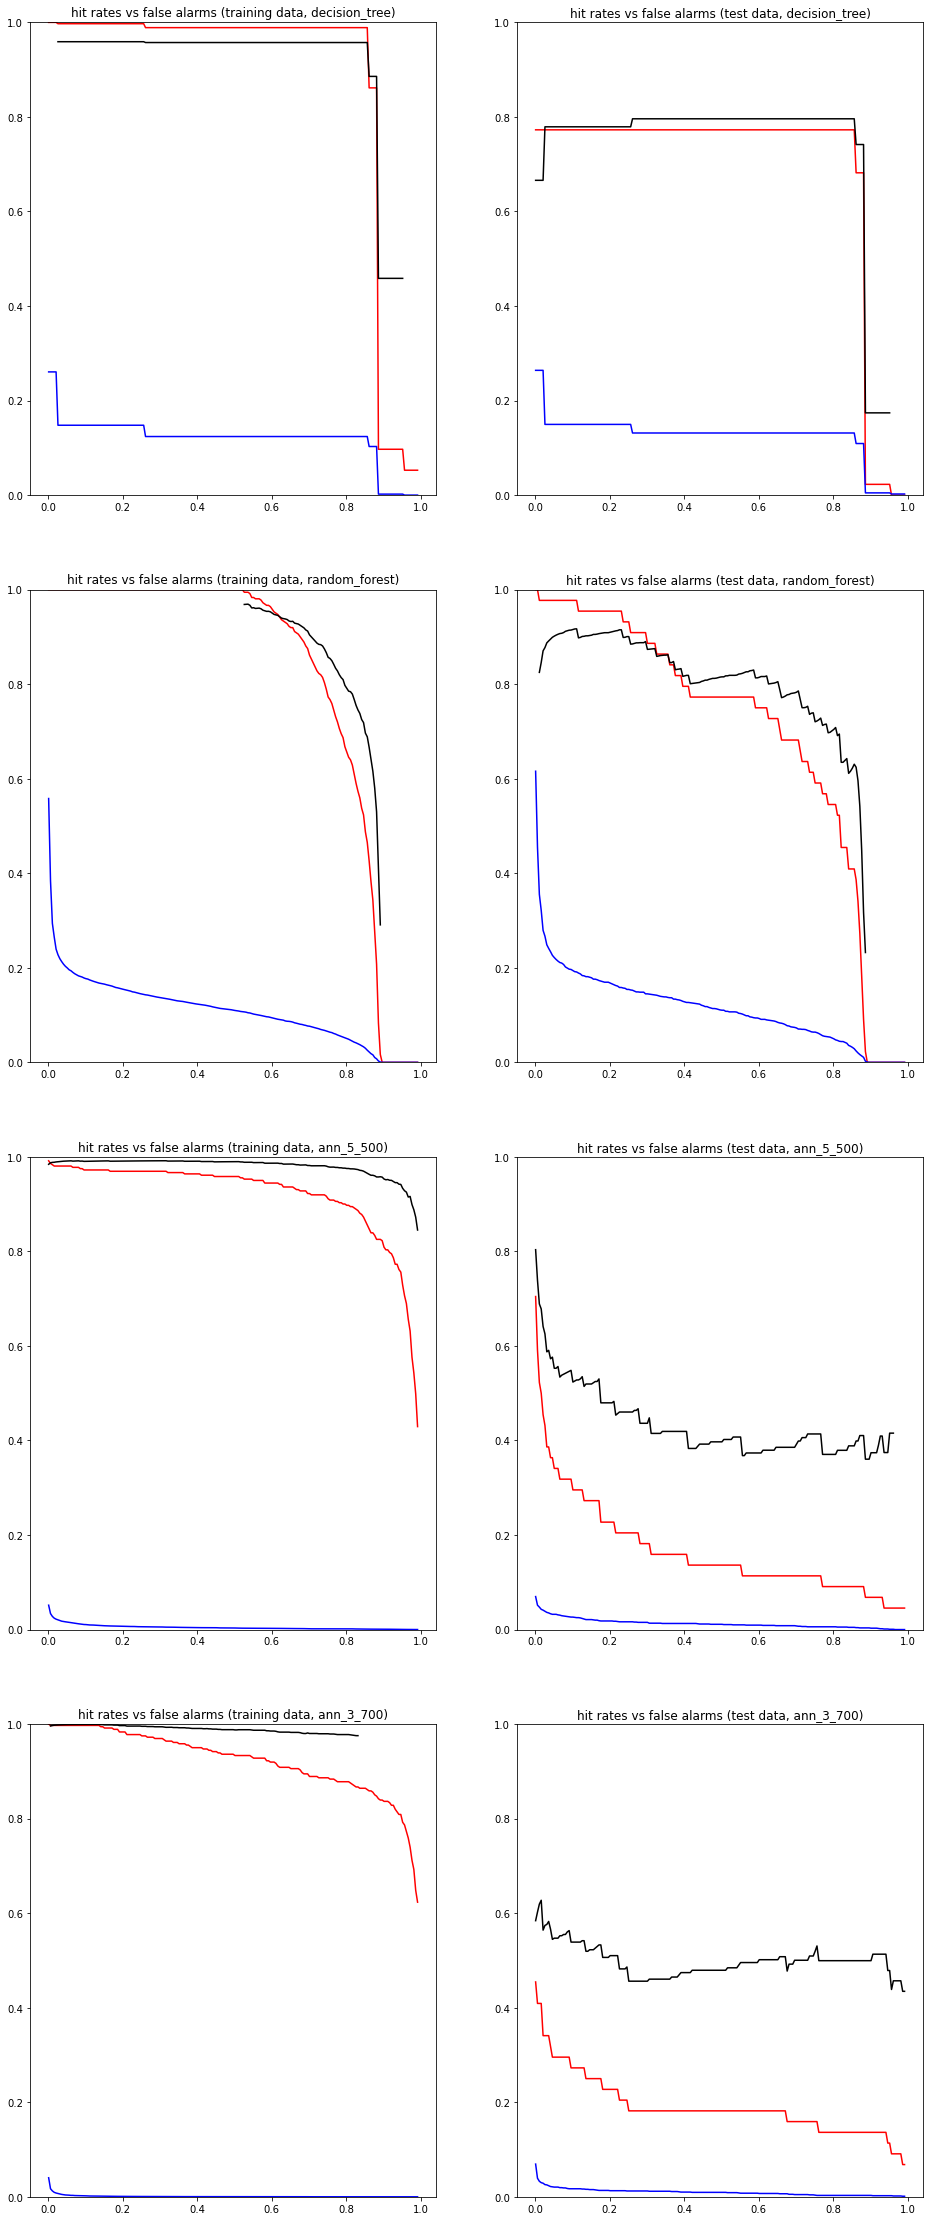

In [108]:
f1 = matplotlib.pyplot.figure(figsize=(16,10*len(classifiers_dict)))

plot_ix = 0
for clf_name, clf1 in classifiers_dict.items():
    ax1 = f1.add_subplot(len(classifiers_dict),2,plot_ix + 1,title=f'hit rates vs false alarms (training data, {clf_name})')
    ax1.plot(thresholds_list, sedi_dict['train'][clf_name]['hit_rates'],'r')
    ax1.plot(thresholds_list, sedi_dict['train'][clf_name]['false_alarm_rates'],'b')
    ax1.plot(thresholds_list, sedi_dict['train'][clf_name]['sedi_list'],'k')
    ax1.set_ylim((0.0,1.0))

    ax1 = f1.add_subplot(len(classifiers_dict),2,plot_ix+2,title=f'hit rates vs false alarms (test data, {clf_name})')
    ax1.plot(thresholds_list, sedi_dict['test'][clf_name]['hit_rates'],'r')
    ax1.plot(thresholds_list, sedi_dict['test'][clf_name]['false_alarm_rates'],'b')
    ax1.plot(thresholds_list, sedi_dict['test'][clf_name]['sedi_list'],'k')
    ax1.set_ylim((0.0,1.0))
    plot_ix += 2

### Resample the data 

Our yes/no classes for classification are very unbalanced, so we can try doing a naive resampling so we have equal representation fo the two classes in our sample set.

In [50]:
data_train_resampled = pandas.concat([
    data_train[data_train[target_feature_name] == True].sample(n=int(1e4), replace=True), 
    data_train[data_train[target_feature_name] == False].sample(n=int(1e4), replace=False),],
    ignore_index=True)

In [51]:
X_train_resampled = preproc_input(data_train_resampled, preproc_dict)
y_train_resampled = preproc_target(data_train_resampled, target_encoder)

In [52]:
train_val_test_res_tuples = [
    (X_train_resampled, y_train_resampled),
    (X_val, y_val),
    (X_test, y_test),    
]

In [53]:
%%time
classifiers_res_dict = {}                    
for clf_name, clf_params in classifiers_params.items():
    print(clf_name)
    clf1 = clf_params['class'](**clf_params['opts'])
    clf1.fit(X_train_resampled, y_train_resampled)
    classifiers_res_dict[clf_name] = clf1

decision_tree
random_forest
ann_5_500
ann_3_700
CPU times: user 16min 20s, sys: 26.3 s, total: 16min 47s
Wall time: 4min 28s


In [113]:
metrics_res, metrics_res_df_list = opmet_metrics.calculate_metric_suite(
    classifiers_res_dict, 
    train_val_test_res_tuples,
)

In [114]:
train_metrics_res_df, val_metrics_res_df, test_metrics_res_df = metrics_res_df_list

<AxesSubplot:title={'center':'false alarm rate (validate) for rotors present class'}, xlabel='classifier'>

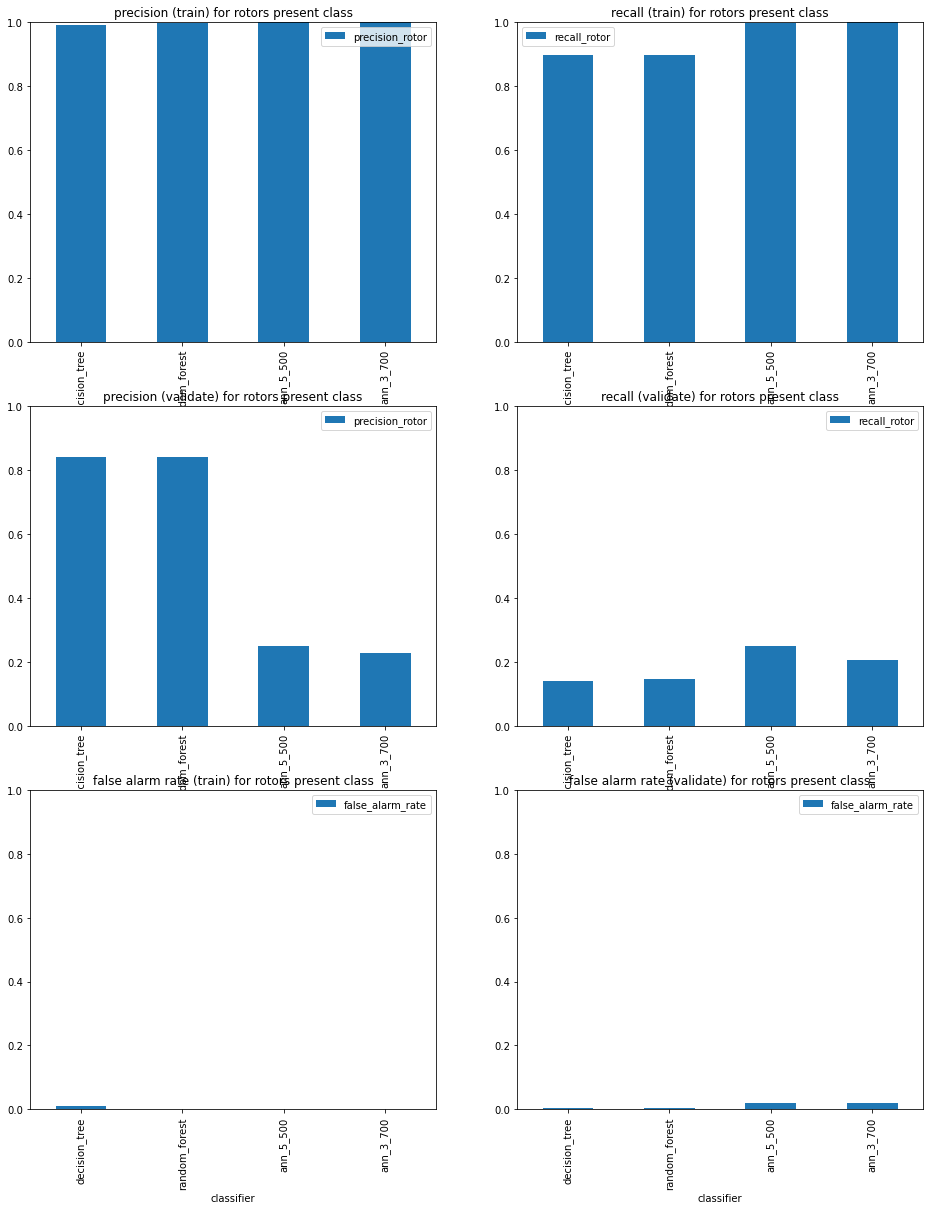

In [115]:
fig1 = matplotlib.pyplot.figure('resampled_data_metrics',figsize=(16,20))
ax1 = fig1.add_subplot(3,2,1,title='precision (train) for rotors present class')
train_metrics_res_df.plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,2,title='recall (train) for rotors present class')
train_metrics_res_df.plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,3,title='precision (validate) for rotors present class')
val_metrics_res_df.plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,4,title='recall (validate) for rotors present class')
val_metrics_res_df.plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,5,title='false alarm rate (train) for rotors present class')
train_metrics_res_df.plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,6,title='false alarm rate (validate) for rotors present class')
val_metrics_res_df.plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])

Calculate SEDI

In [110]:
sedi_res_dict = {}
for set_name, (X1, y1) in train_test_dict.items():
    set_sedi_dict = {}
    for clf_name, clf1 in classifiers_res_dict.items():
        y_pred_raw = clf1.predict_proba(X1)[:,1]
        set_sedi_dict[clf_name] = opmet_metrics.calculate_sedi_suite(thresholds_list,
                                                                     y1, 
                                                                     y_pred_raw)
        
    sedi_res_dict[set_name] = set_sedi_dict     

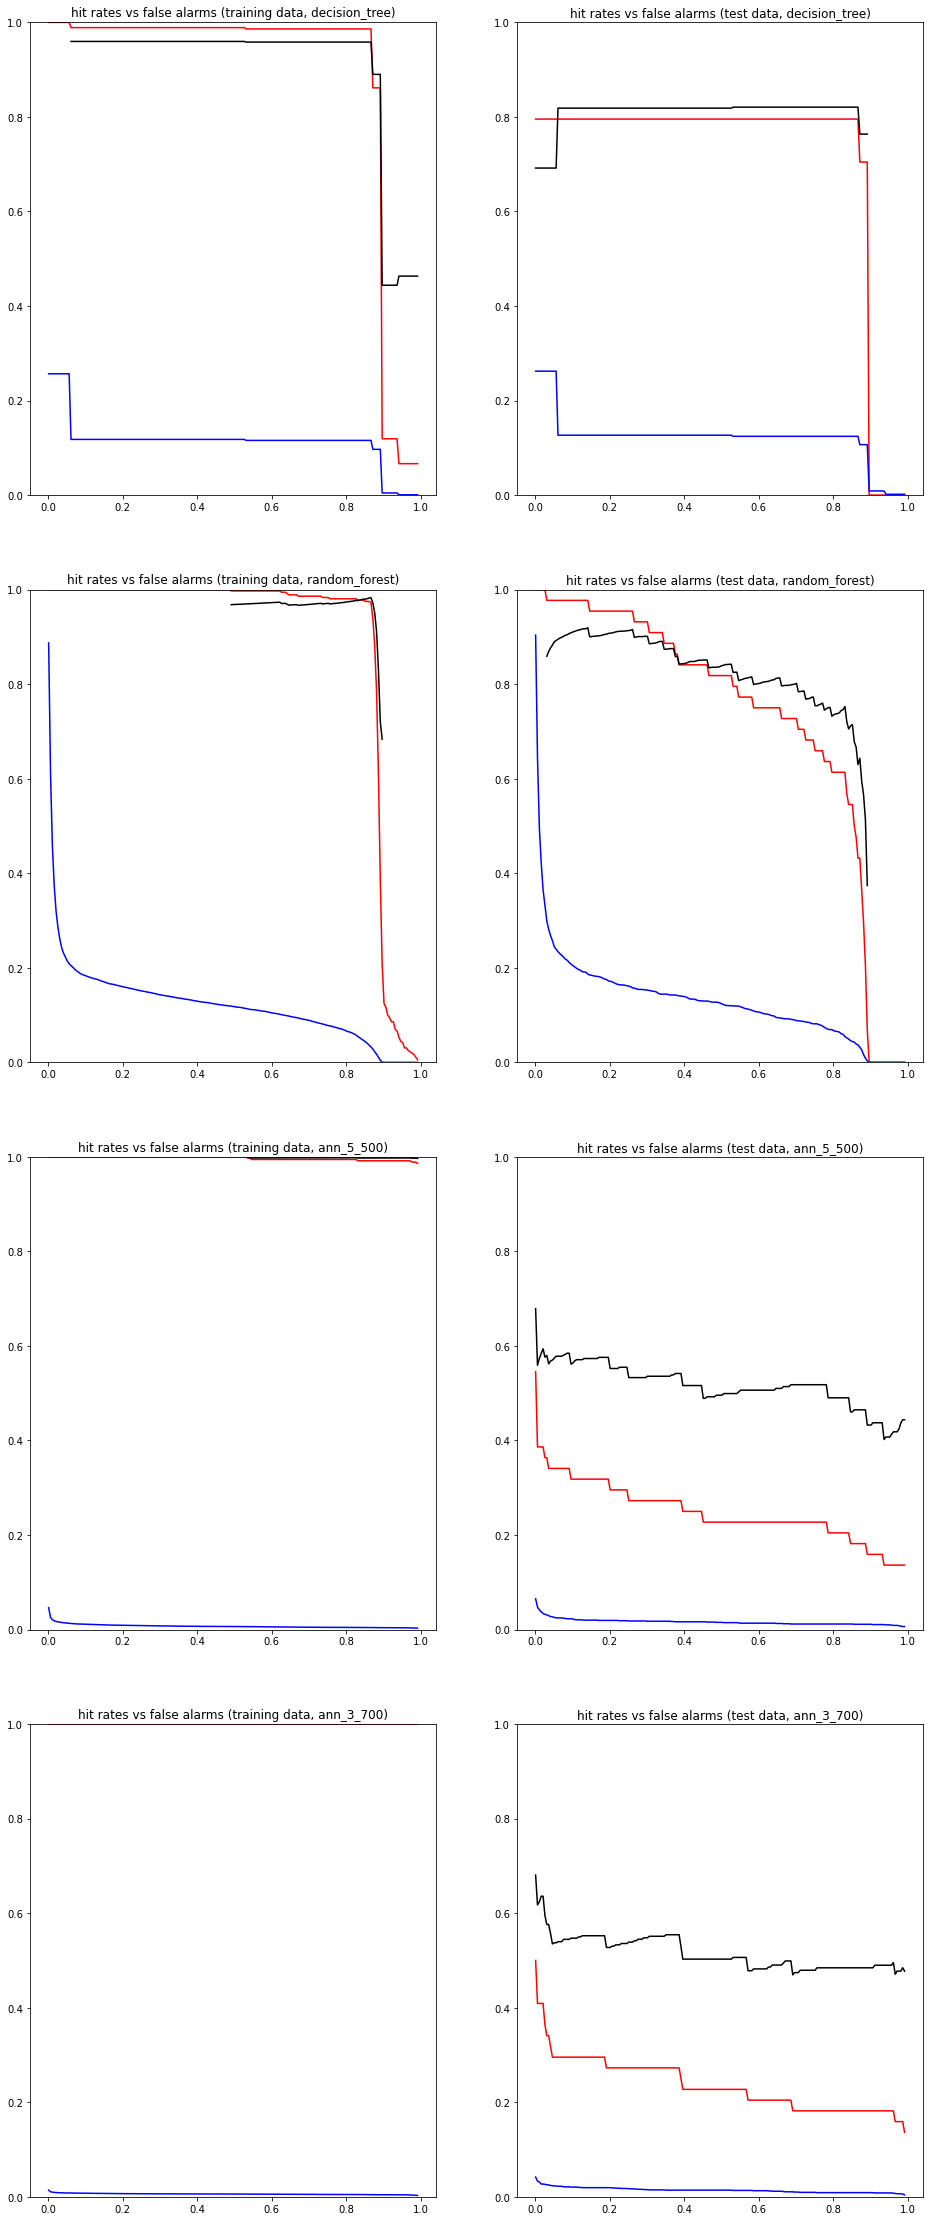

In [112]:
f1 = matplotlib.pyplot.figure(figsize=(16,10*len(classifiers_res_dict)))

plot_ix = 0
for clf_name, clf1 in classifiers_dict.items():
    ax1 = f1.add_subplot(len(classifiers_res_dict),2,plot_ix + 1,title=f'hit rates vs false alarms (training data, {clf_name})')
    ax1.plot(thresholds_list, sedi_res_dict['train'][clf_name]['hit_rates'],'r')
    ax1.plot(thresholds_list, sedi_res_dict['train'][clf_name]['false_alarm_rates'],'b')
    ax1.plot(thresholds_list, sedi_res_dict['train'][clf_name]['sedi_list'],'k')
    ax1.set_ylim((0.0,1.0))

    ax1 = f1.add_subplot(len(classifiers_res_dict),2,plot_ix+2,title=f'hit rates vs false alarms (test data, {clf_name})')
    ax1.plot(thresholds_list, sedi_res_dict['test'][clf_name]['hit_rates'],'r')
    ax1.plot(thresholds_list, sedi_res_dict['test'][clf_name]['false_alarm_rates'],'b')
    ax1.plot(thresholds_list, sedi_res_dict['test'][clf_name]['sedi_list'],'k')
    ax1.set_ylim((0.0,1.0))
    plot_ix += 2

### Including observations

Other challenge participants have used observations as input. This makes it less of a forecast and more of a nowcast, but would be good for comparing.

In [116]:
input_feature_names_obs = obs_feature_names + temp_feature_names + humidity_feature_names + u_wind_feature_names + v_wind_features_names

In [117]:
preproc_dict_obs = {}
for if1 in input_feature_names_obs:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(data_train[[if1]])
    preproc_dict_obs[if1] = scaler1

In [118]:
X_train_obs = preproc_input(data_train, preproc_dict_obs)
y_train_obs = preproc_target(data_train, target_encoder)

In [119]:
X_val_obs = preproc_input(data_validation, preproc_dict_obs)
y_val_obs = preproc_target(data_validation, target_encoder)

In [120]:
X_test_obs = preproc_input(data_test, preproc_dict_obs)
y_test_obs = preproc_target(data_test, target_encoder)

In [126]:
train_test_obs_dict = {
    'train': (X_train_obs, y_train_obs),
    'validate': (X_val_obs, y_val_obs),
    'test': (X_test_obs, y_test_obs),    
}
train_val_test_obs_tuples = list(train_test_obs_dict.values())

In [122]:
%%time
classifiers_obs_dict = {}                    
for clf_name, clf_params in classifiers_params.items():
    print(clf_name)
    clf1 = clf_params['class'](**clf_params['opts'])
    clf1.fit(X_train_obs, y_train_obs)
    classifiers_obs_dict[clf_name] = clf1

decision_tree
random_forest
ann_5_500
ann_3_700
CPU times: user 27min 58s, sys: 29.7 s, total: 28min 28s
Wall time: 7min 29s


In [123]:
metrics_obs, metrics_obs_df_list = opmet_metrics.calculate_metric_suite(
    classifiers_obs_dict, 
    train_val_test_obs_tuples,
)

In [124]:
train_metrics_obs_df, val_metrics_obs_df, test_metrics_obs_df = metrics_obs_df_list

<AxesSubplot:title={'center':'false alarm rate (validate) for rotors present class'}, xlabel='classifier'>

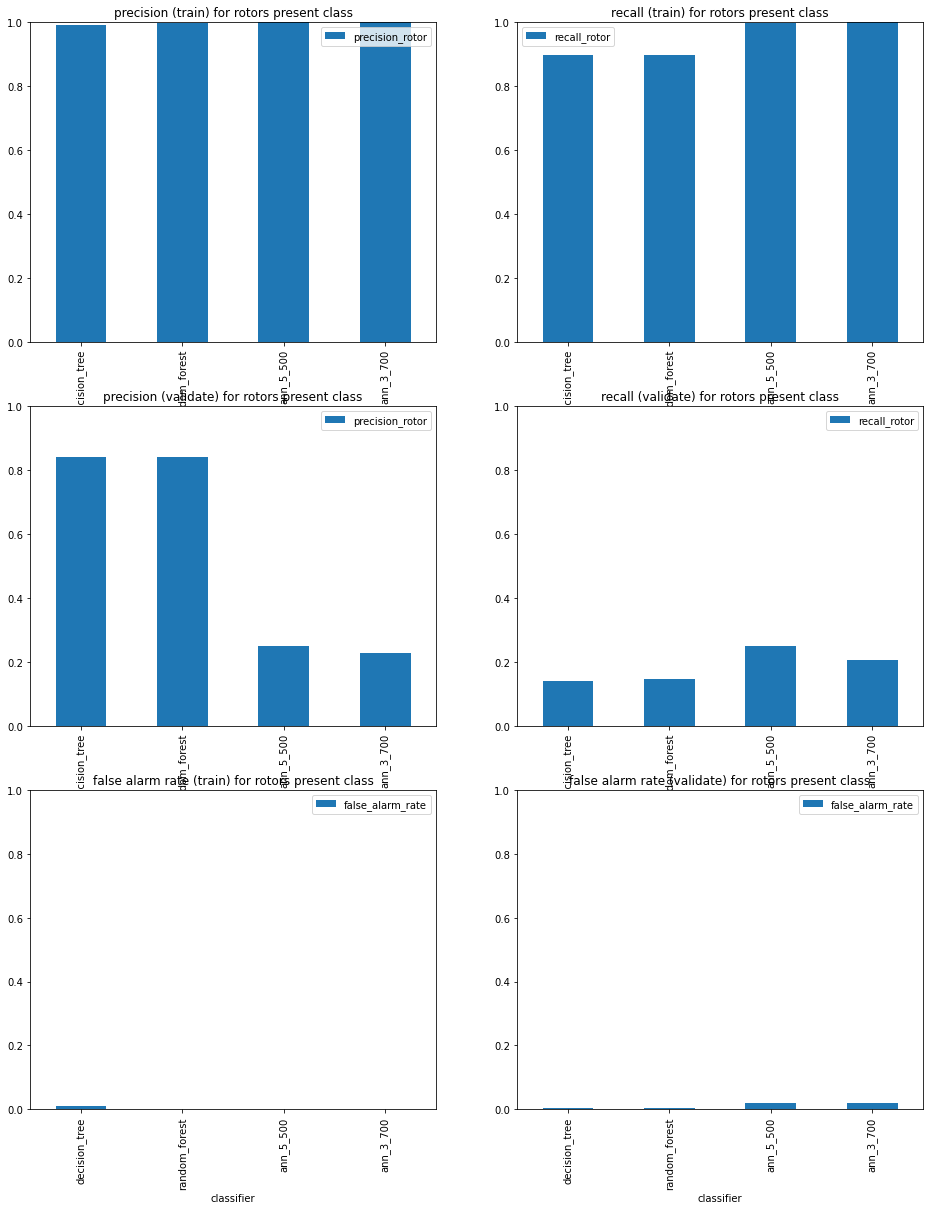

In [125]:
fig1 = matplotlib.pyplot.figure('resampled_data_metrics',figsize=(16,20))
ax1 = fig1.add_subplot(3,2,1,title='precision (train) for rotors present class')
train_metrics_res_df.plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,2,title='recall (train) for rotors present class')
train_metrics_res_df.plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,3,title='precision (validate) for rotors present class')
val_metrics_res_df.plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,4,title='recall (validate) for rotors present class')
val_metrics_res_df.plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,5,title='false alarm rate (train) for rotors present class')
train_metrics_res_df.plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,6,title='false alarm rate (validate) for rotors present class')
val_metrics_res_df.plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])

Calculate sedi metrics

In [127]:
sedi_obs_dict = {}
for set_name, (X1, y1) in train_test_obs_dict.items():
    set_sedi_dict = {}
    for clf_name, clf1 in classifiers_obs_dict.items():
        y_pred_raw = clf1.predict_proba(X1)[:,1]
        set_sedi_dict[clf_name] = opmet_metrics.calculate_sedi_suite(thresholds_list,
                                                                     y1, 
                                                                     y_pred_raw)
        
    sedi_obs_dict[set_name] = set_sedi_dict     

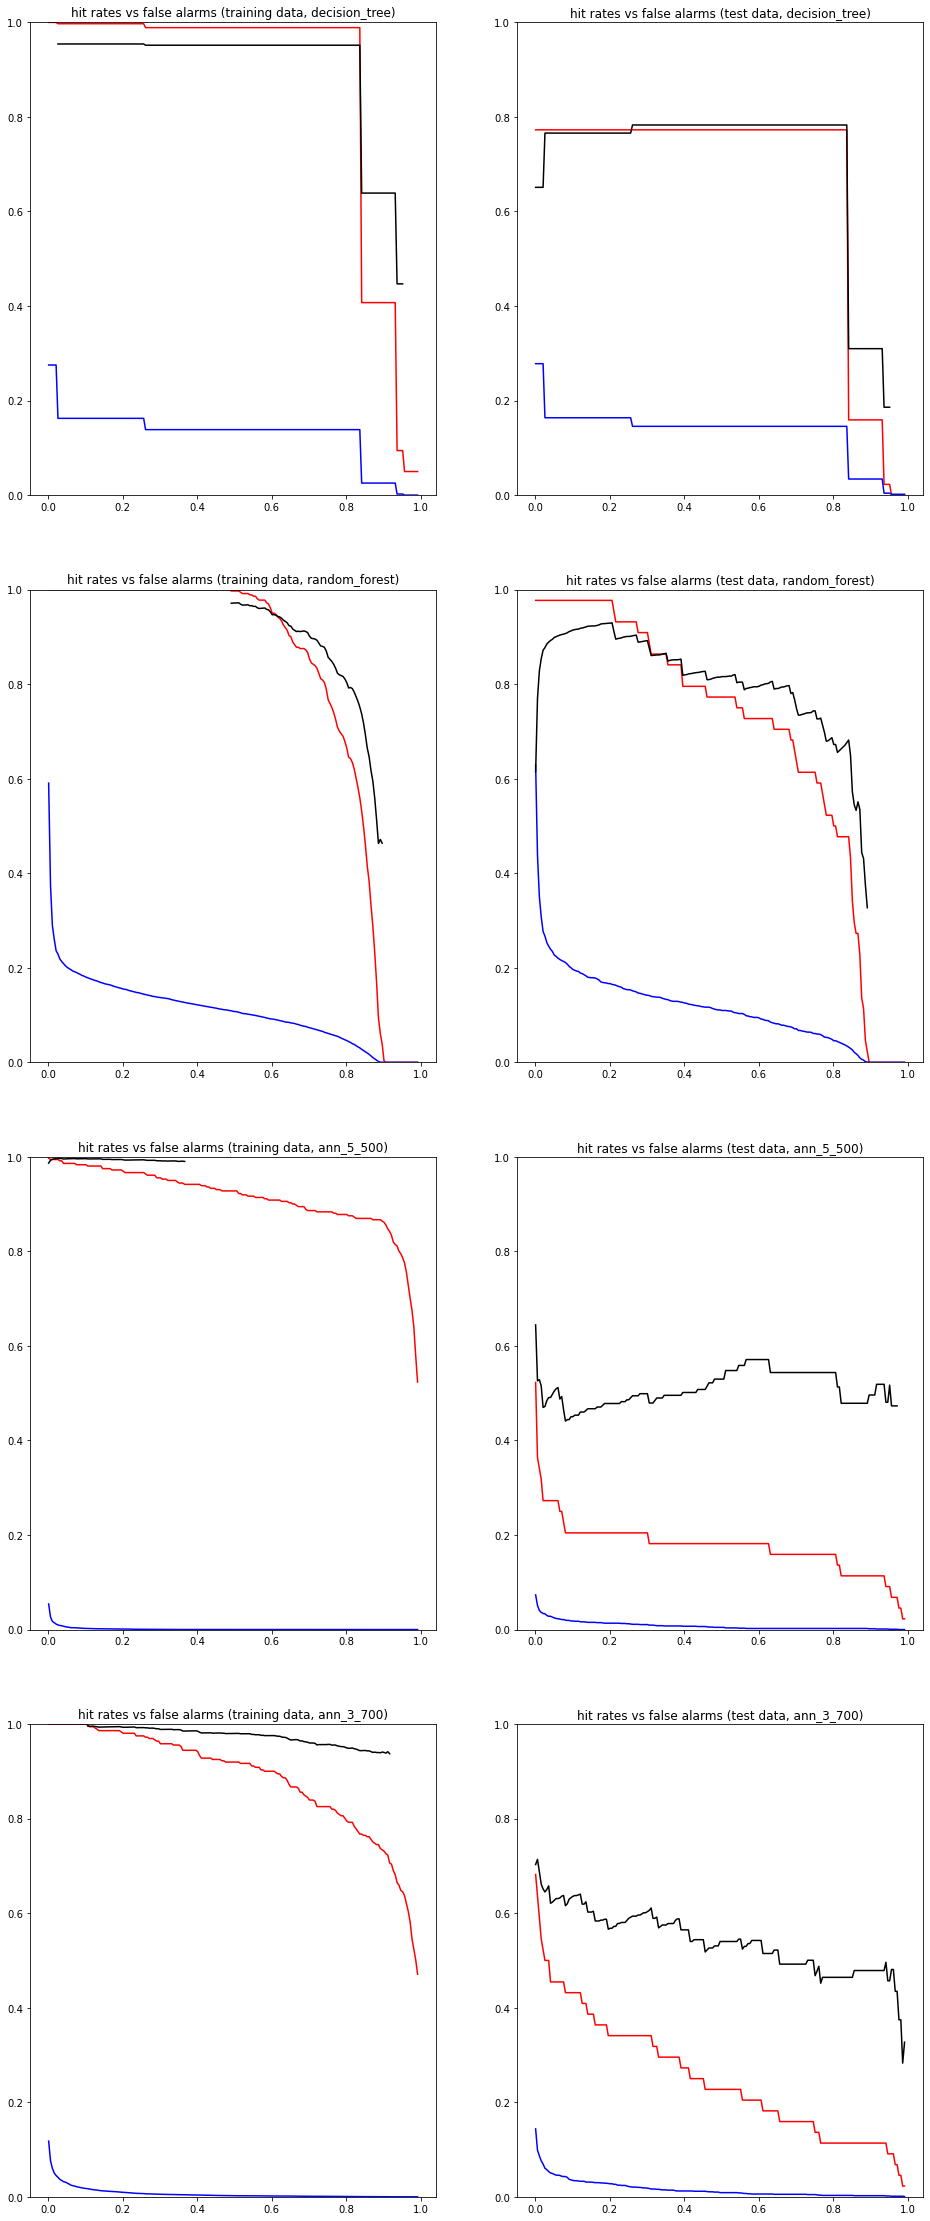

In [128]:
f1 = matplotlib.pyplot.figure(figsize=(16,10*len(classifiers_obs_dict)))

plot_ix = 0
for clf_name, clf1 in classifiers_obs_dict.items():
    ax1 = f1.add_subplot(len(classifiers_obs_dict),2,plot_ix + 1,title=f'hit rates vs false alarms (training data, {clf_name})')
    ax1.plot(thresholds_list, sedi_obs_dict['train'][clf_name]['hit_rates'],'r')
    ax1.plot(thresholds_list, sedi_obs_dict['train'][clf_name]['false_alarm_rates'],'b')
    ax1.plot(thresholds_list, sedi_obs_dict['train'][clf_name]['sedi_list'],'k')
    ax1.set_ylim((0.0,1.0))

    ax1 = f1.add_subplot(len(classifiers_obs_dict),2,plot_ix+2,title=f'hit rates vs false alarms (test data, {clf_name})')
    ax1.plot(thresholds_list, sedi_obs_dict['test'][clf_name]['hit_rates'],'r')
    ax1.plot(thresholds_list, sedi_obs_dict['test'][clf_name]['false_alarm_rates'],'b')
    ax1.plot(thresholds_list, sedi_obs_dict['test'][clf_name]['sedi_list'],'k')
    ax1.set_ylim((0.0,1.0))
    plot_ix += 2